In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from hardwares.hardware_params import hardware_params
from model_analyzer import ModelAnalyzer
%load_ext autoreload
%autoreload 2

In [2]:
model_id="meta-llama/Llama-2-13b-hf"
hardware="nvidia_A6000"
analyzer=ModelAnalyzer(model_id,hardware)
hardware_memory=48 # GB


use config file configs/Llama.py for meta-llama/Llama-2-13b-hf


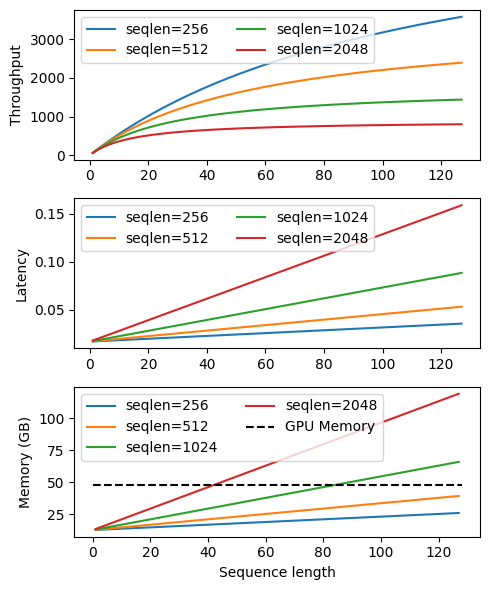

In [3]:
fig=plt.figure(figsize=(5, 6))
plt.subplot(3,1,1)
for seqlen in [256,512,1024,2048]:
    ys=[]
    xs=[]
    for batchsize in range(1,128):
        result=analyzer.analyze(seqlen,batchsize,8,8,8)
        # result=analyzer.analyze(seqlen,batchsize,16,16,16,use_flashattention=True)
        inference_time=result["total_results"]["decode"]["inference_time"]
        throughput=batchsize/inference_time
        ys.append(throughput)
        # ys.append(inference_time)
        xs.append(batchsize)
    plt.plot(xs,ys,label=f"seqlen={seqlen}")
plt.legend(ncol=2)
plt.ylabel("Throughput")
# plt.xlabel("Sequence length")

plt.subplot(3,1,2)
for seqlen in [256,512,1024,2048]:
    ys=[]
    xs=[]
    for batchsize in range(1,128):
        # result=analyzer.analyze(seqlen,batchsize,16,16,16,use_flashattention=True)
        result=analyzer.analyze(seqlen,batchsize,8,8,8)
        inference_time=result["total_results"]["decode"]["inference_time"]
        # inference_time=result["total_results"]["decode"]["memory_consumption"]/1e9
        throughput=batchsize/inference_time
        # ys.append(throughput)
        ys.append(inference_time)
        xs.append(batchsize)
    plt.plot(xs,ys,label=f"seqlen={seqlen}")
plt.legend(ncol=2)
plt.ylabel("Latency")
# plt.xlabel("Sequence length")


plt.subplot(3,1,3)
for seqlen in [256,512,1024,2048]:
    ys=[]
    xs=[]
    for batchsize in range(1,128):
        # result=analyzer.analyze(seqlen,batchsize,16,16,16,use_flashattention=True)
        result=analyzer.analyze(seqlen,batchsize,8,8,8)
        # inference_time=result["total_results"]["decode"]["inference_time"]
        inference_time=result["total_results"]["decode"]["memory_consumption"]/1e9
        throughput=batchsize/inference_time
        # ys.append(throughput)
        ys.append(inference_time)
        xs.append(batchsize)
    plt.plot(xs,ys,label=f"seqlen={seqlen}")
plt.hlines(hardware_memory,0,128,linestyles="dashed",label="GPU Memory",colors="black")
plt.legend(ncol=2)
plt.ylabel("Memory (GB)")
plt.xlabel("Sequence length")

plt.tight_layout()
plt.savefig("../output/parallel_serving.pdf",bbox_inches='tight')

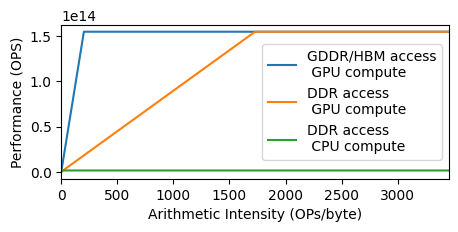

In [23]:
# plot offloading

def draw_roofline(bandwidth, max_OPS,dtype):
    # bandwidth is bytes/s
    # x axis is mac/byte
    # y axis is mac/s
    
    y_max = max_OPS
    turning_point = y_max / bandwidth

    plt.plot(
        [0, turning_point, turning_point * 300], [0, y_max, y_max], label=dtype
    )
    
    
fig=plt.figure(figsize=(5, 2))

hardware="nvidia_A6000"
bandwidth = hardware_params[hardware]["bandwidth"]
max_OPS = hardware_params[hardware]["FP16"]
draw_roofline(bandwidth, max_OPS,"GDDR/HBM access\n GPU compute")

hardware="intel_13900k"
bandwidth = hardware_params[hardware]["bandwidth"]
draw_roofline(bandwidth, max_OPS,"DDR access\n GPU compute")
plt.xlim(0, max_OPS / bandwidth * 2)
max_OPS = hardware_params[hardware]["FP16"]
draw_roofline(bandwidth, max_OPS,"DDR access\n CPU compute")
plt.legend()
plt.xlabel("Arithmetic Intensity (OPs/byte)")
plt.ylabel("Performance (OPS)")
# save pdf
plt.savefig(f"../output/offloading_roofline.pdf", bbox_inches="tight")